In [242]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm 
import torch

from torch import nn, distributions
from torch.distributions import constraints
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm

rng = np.random.RandomState(1234)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# MCMC

Taken from PyMC tutorial here: https://www.pymc.io/projects/examples/en/latest/case_studies/stochastic_volatility.html

$\sigma \sim Exponential(10)$

$\nu \sim Exponential(.1)$

$s_i \sim Normal(s_{i-1}, \sigma^2)$

$\log(r_i) \sim t(\nu, 0, \exp(-2 s_i))$

In [91]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()


,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


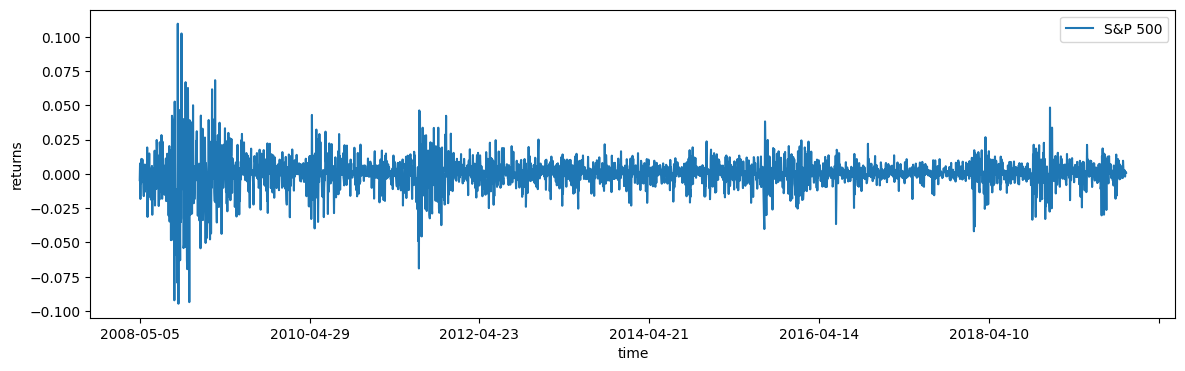

In [80]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [14]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/pymc/distributions/timeseries.py:292: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


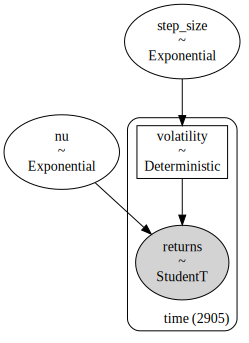

In [15]:
pm.model_to_graphviz(stochastic_vol_model)

In [16]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = idata.prior_predictive.stack(pooled_chain=("chain", "draw"))


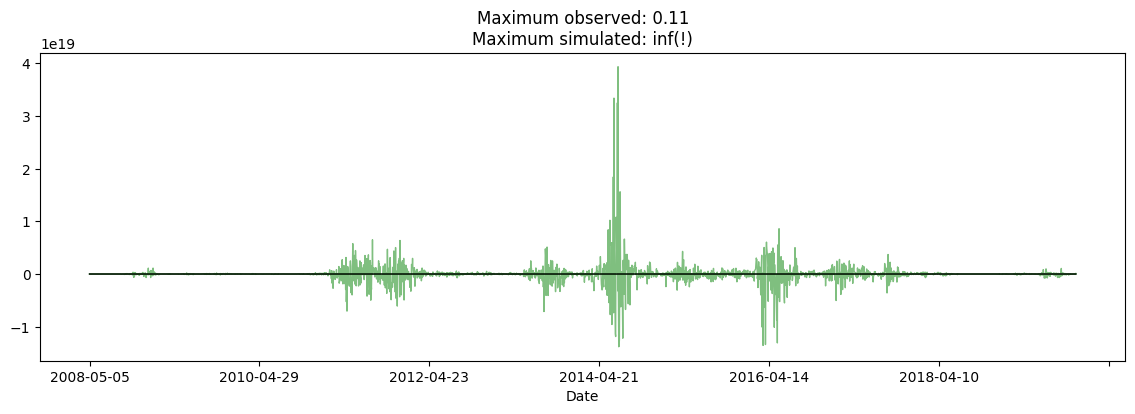

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [15]:
with stochastic_vol_model:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 891 seconds.
/home/brian/devel/sandbox/stochastic_langevin/venv/lib/python3.10/site-packages/aeppl/joint_logprob.py:127: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(


In [16]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))


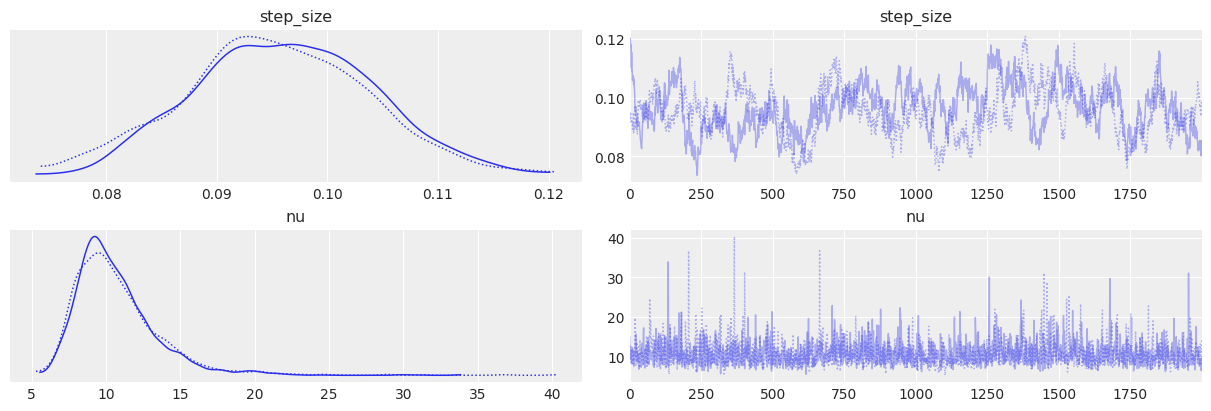

In [17]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

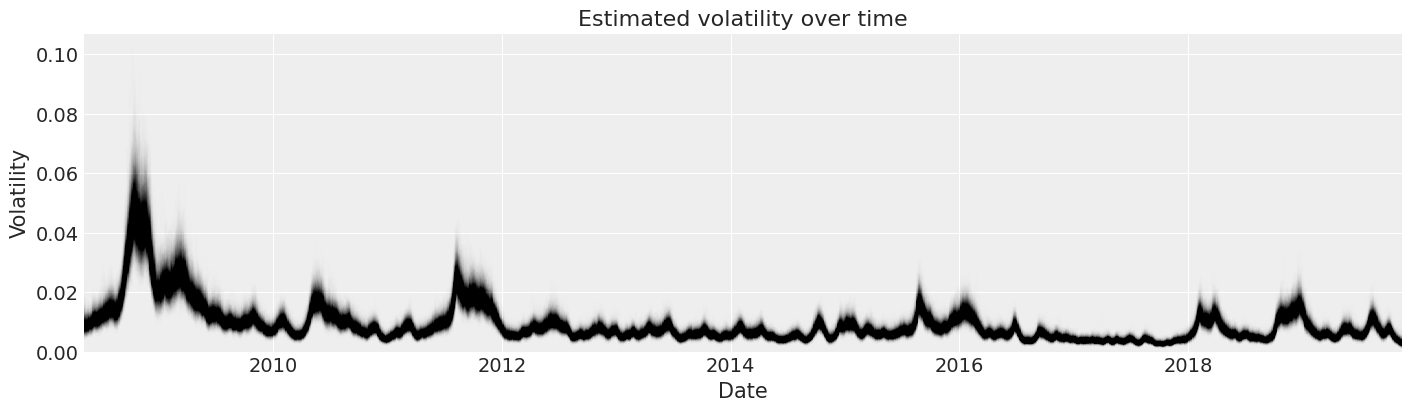

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

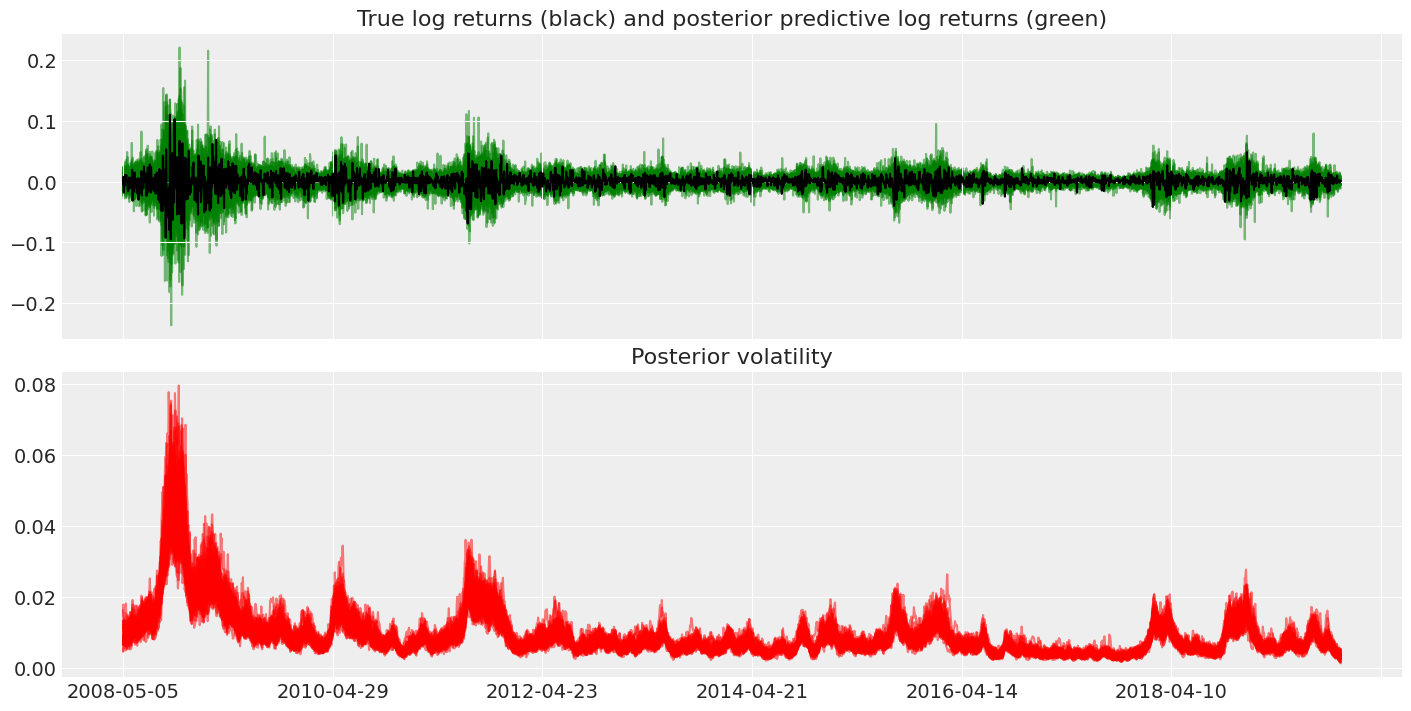

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"].isel(pooled_chain=slice(None, None, 100)),
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

# SGLD Torch Models

$X_i = log(r_i)$

$
p(s_i, \nu, \sigma | {\bf x}) = [\Pi_ip(x_i | s_i, \nu, \sigma) p(s_i | s_{i-1}, \sigma)] p(\nu) p(\sigma)
$

In [780]:
class StochasticVolatility(nn.Module):
    def __init__(self, trace_len, sigma_lambda=10., nu_lambda=0.1):
        super(StochasticVolatility, self).__init__()
        
        self.sigma_rv = distributions.Exponential(torch.tensor(sigma_lambda))
        self.sigma = nn.Parameter(torch.tensor(10.))
        self.nu_rv = distributions.Exponential(torch.tensor(sigma_lambda))
        self.nu = nn.Parameter(self.nu_rv.mean)
        self.vol = nn.Parameter(torch.zeros(trace_len))
        nn.init.normal_(self.vol, std=0.001)
        
        self.init_vol = nn.Parameter(torch.tensor(-4.5))
      
    def returns_rv(self, vol_samples):
        # Uses \sigma parameterization, not \lambda as PyMC model above
        # See: https://en.wikipedia.org/wiki/Student%27s_t-distribution#In_terms_of_scaling_parameter_%CF%83%CC%82_or_%CF%83%CC%822
        return distributions.StudentT(df=self.nu * torch.ones(vol_samples.shape), 
                                      loc=torch.zeros(vol_samples.shape), 
                                      scale=torch.exp(vol_samples))

    def forward(self):
        sigma_rv = distributions.Exponential(self.sigma)
        sigma_sample = sigma_rv.rsample()
        
        vol_rv = distributions.Normal(self.vol, 
                                      sigma_sample * torch.ones(self.vol.shape))
        vol_diffs = vol_rv.rsample()
        vol_samples = self.init_vol + torch.cumsum(vol_diffs, dim=0) 
        
        print(f'* init_vol = {self.init_vol}')
        print(f'* vol = {self.vol}')
        print(f'* vol_diffs = {vol_diffs}')
        print(f'* vol_samples = {vol_samples}')
        print(f'* t-scale = {torch.exp(vol_samples)}')
        print(f'* sigma = {self.sigma}')
        print(f'* sigma_sample = {sigma_sample}')
        print(f'* nu = {self.nu}')
        return self.returns_rv(vol_samples).mean, vol_samples

    def loss(self, r_obs, vol_samples):
        likelihood = self.returns_rv(vol_samples).log_prob(r_obs)
       
        vol_rv = distributions.Normal(loc=torch.zeros(self.vol.shape),
                                      scale=self.sigma * torch.ones(self.vol.shape))
        vol_prior = vol_rv.log_prob(self.vol)
       
        # Prior for each timestep
        sigma_prior = self.sigma_rv.log_prob(self.sigma)
        nu_prior = self.nu_rv.log_prob(self.nu)
        
        print(f'll = {likelihood.sum():.3f}, vol_prior = {vol_prior.sum():.3f}, sigma_prior = {sigma_prior:.3f}, nu_prior = {nu_prior:.3f}')
        return -(likelihood.sum() + vol_prior.sum() + sigma_prior + nu_prior) / len(r_obs)
        #return -(likelihood.sum() + sigma_prior + nu_prior) / len(r_obs)

# SGLD

In [781]:
torch_data = torch.tensor(returns['change'])
torch_data, len(torch_data)

(tensor([-0.0045,  0.0076, -0.0183,  ...,  0.0016,  0.0007,  0.0008],
        dtype=torch.float64),
 2905)

In [782]:
torch_model = StochasticVolatility(len(torch_data), sigma_lambda=10, nu_lambda=0.1)
lr = 0.001
EPSILON = 1e-6
param_group_1 = [p for name, p in torch_model.named_parameters() if name not in {'init_vol', 'sigma'}]
param_group_2 = [torch_model.init_vol]
param_group_3 = [torch_model.sigma]
optimizer = optim.SGD([{'params': param_group_1},
                       {'params': param_group_2, 'lr': lr},
                       {'params': param_group_3, 'lr': lr},
                      ],
                      lr=lr)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

epoch = 0
for epoch in range(100):
    torch_model.zero_grad()
    
    r_samples, s_samples = torch_model()
    loss = torch_model.loss(torch_data, s_samples)
    loss.backward()
    #if torch_model.sigma - 0.00001 * torch_model.sigma.grad < EPSILON:
    #    torch_model.sigma.grad = (torch_model.sigma.clone() - EPSILON)
    #    print(f'**********HERE')
    torch.nn.utils.clip_grad_norm_(torch_model.sigma, max_norm=50.)
    #torch.nn.utils.clip_grad_norm_(torch_model.vol, max_norm=100.)
    print(f'torch_model.sigma.grad = {torch_model.sigma.grad}')
    print(f'torch_model.vol.grad = {torch_model.vol.grad}')
    print(f'torch_model.init_vol.grad = {torch_model.init_vol.grad}')
    #if epoch + 1 == 8:
    #    break
        
    optimizer.step()

    print(f'[epoch={epoch+1}] loss: {loss.item():.5f}')
    print(f'========================================')
        
for name, param in torch_model.named_parameters():
    print(f'{name} = {param}')

* init_vol = -4.5
* vol = Parameter containing:
tensor([ 0.0014, -0.0015, -0.0013,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([ 0.0036, -0.0429, -0.0064,  ..., -0.0277,  0.0173, -0.0177],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([-4.4964, -4.5393, -4.5457,  ..., -6.4797, -6.4624, -6.4801],
       grad_fn=<AddBackward0>)
* t-scale = tensor([0.0111, 0.0107, 0.0106,  ..., 0.0015, 0.0016, 0.0015],
       grad_fn=<ExpBackward0>)
* sigma = 10.0
* sigma_sample = 0.023336682468652725
* nu = 0.10000000149011612
ll = 6159.357, vol_prior = -9358.527, sigma_prior = -97.697, nu_prior = 1.303
torch_model.sigma.grad = 0.11028169840574265
torch_model.vol.grad = tensor([6.3342e-02, 6.3234e-02, 6.3207e-02,  ..., 1.4833e-04, 1.4949e-04,
        6.0813e-05])
torch_model.init_vol.grad = 0.06334211677312851
[epoch=1] loss: 1.13445
* init_vol = -4.500063419342041
* vol = Parameter containing:
tensor([ 0.0013, -0.0015, -0.0014,  ...,  0.0008,  0.0014,  0.000

torch_model.sigma.grad = 0.05631915479898453
torch_model.vol.grad = tensor([0.1352, 0.1351, 0.1351,  ..., 0.0006, 0.0005, 0.0002])
torch_model.init_vol.grad = 0.13524863123893738
[epoch=17] loss: 0.87728
* init_vol = -4.503698825836182
* vol = Parameter containing:
tensor([-0.0023, -0.0052, -0.0050,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([-0.2914, -0.3904,  0.1914,  ..., -0.1215,  0.3840, -0.2597],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([ -4.7951,  -5.1855,  -4.9941,  ..., -28.6504, -28.2664, -28.5261],
       grad_fn=<AddBackward0>)
* t-scale = tensor([8.2700e-03, 5.5972e-03, 6.7781e-03,  ..., 3.6082e-13, 5.2975e-13,
        4.0859e-13], grad_fn=<ExpBackward0>)
* sigma = 10.000411033630371
* sigma_sample = 0.30516427755355835
* nu = 0.1640036702156067
ll = 1277.005, vol_prior = -9358.645, sigma_prior = -97.702, nu_prior = 0.663
torch_model.sigma.grad = -0.1482454240322113
torch_model.vol.grad = tensor([ 1.6151e-01,  1.6143e-01,

torch_model.sigma.grad = 0.09083744883537292
torch_model.vol.grad = tensor([0.0299, 0.0298, 0.0297,  ..., 0.0008, 0.0006, 0.0003])
torch_model.init_vol.grad = 0.029948312789201736
[epoch=33] loss: 0.74912
* init_vol = -4.503545761108398
* vol = Parameter containing:
tensor([-0.0021, -0.0050, -0.0048,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([-0.0147, -0.0209,  0.0661,  ..., -0.0424,  0.0054,  0.0778],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([-4.5183, -4.5391, -4.4731,  ..., -6.5460, -6.5407, -6.4628],
       grad_fn=<AddBackward0>)
* t-scale = tensor([0.0109, 0.0107, 0.0114,  ..., 0.0014, 0.0014, 0.0016],
       grad_fn=<ExpBackward0>)
* sigma = 9.999980926513672
* sigma_sample = 0.0649421364068985
* nu = 0.1851198375225067
ll = 6799.065, vol_prior = -9358.521, sigma_prior = -97.697, nu_prior = 0.451
torch_model.sigma.grad = 0.029062673449516296
torch_model.vol.grad = tensor([2.6445e-01, 2.6430e-01, 2.6426e-01,  ..., 2.0019e-04, 2.

* init_vol = -4.503623008728027
* vol = Parameter containing:
tensor([-0.0022, -0.0051, -0.0049,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([-0.0099, -0.0021,  0.0139,  ..., -0.0029,  0.0665,  0.0455],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([-4.5135, -4.5156, -4.5018,  ..., -6.3309, -6.2644, -6.2188],
       grad_fn=<AddBackward0>)
* t-scale = tensor([0.0110, 0.0109, 0.0111,  ..., 0.0018, 0.0019, 0.0020],
       grad_fn=<ExpBackward0>)
* sigma = 10.001564979553223
* sigma_sample = 0.038056790828704834
* nu = 0.19894778728485107
ll = 6385.030, vol_prior = -9358.981, sigma_prior = -97.713, nu_prior = 0.313
torch_model.sigma.grad = -0.028878681361675262
torch_model.vol.grad = tensor([4.3410e-01, 4.3395e-01, 4.3390e-01,  ..., 3.4035e-04, 3.2419e-04,
        1.5022e-04])
torch_model.init_vol.grad = 0.43410396575927734
[epoch=50] loss: 1.05726
* init_vol = -4.504056930541992
* vol = Parameter containing:
tensor([-0.0026, -0.0055, -0.0054,

* vol_samples = tensor([-4.5071, -4.5122, -4.5144,  ..., -9.6100, -9.6107, -9.6094],
       grad_fn=<AddBackward0>)
* t-scale = tensor([1.1030e-02, 1.0974e-02, 1.0950e-02,  ..., 6.7054e-05, 6.7011e-05,
        6.7095e-05], grad_fn=<ExpBackward0>)
* sigma = 10.002434730529785
* sigma_sample = 0.008336021564900875
* nu = 0.20144855976104736
ll = 6879.162, vol_prior = -9359.232, sigma_prior = -97.722, nu_prior = 0.288
torch_model.sigma.grad = 0.1027197614312172
torch_model.vol.grad = tensor([-1.3954e-01, -1.3970e-01, -1.3975e-01,  ..., -2.0661e-04,
        -1.3741e-04, -6.8809e-05])
torch_model.init_vol.grad = -0.13954301178455353
[epoch=66] loss: 0.88726
* init_vol = -4.504286289215088
* vol = Parameter containing:
tensor([-0.0029, -0.0057, -0.0056,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([ 0.1517, -0.1503, -0.0468,  ...,  0.1114, -0.1413, -0.0982],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([-4.3526, -4.5029, -4.5497,  ...,  5.8018,  

* nu = 0.20122411847114563
ll = -6365.682, vol_prior = -9359.305, sigma_prior = -97.724, nu_prior = 0.290
torch_model.sigma.grad = -0.7289299964904785
torch_model.vol.grad = tensor([9.2740e-01, 9.2724e-01, 9.2717e-01,  ..., 1.0327e-03, 6.8847e-04,
        3.4423e-04])
torch_model.init_vol.grad = 0.9274033308029175
[epoch=82] loss: 5.44662
* init_vol = -4.505412578582764
* vol = Parameter containing:
tensor([-0.0040, -0.0069, -0.0067,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([ 0.0304, -0.1353,  0.1075,  ...,  0.4028, -0.0723,  0.1475],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([ -4.4750,  -4.6103,  -4.5029,  ..., -12.6945, -12.7668, -12.6193],
       grad_fn=<AddBackward0>)
* t-scale = tensor([1.1390e-02, 9.9486e-03, 1.1077e-02,  ..., 3.0680e-06, 2.8539e-06,
        3.3075e-06], grad_fn=<ExpBackward0>)
* sigma = 10.003411293029785
* sigma_sample = 0.1718003749847412
* nu = 0.20324578881263733
ll = 5245.119, vol_prior = -9359.518, sigm

* init_vol = -4.504778861999512
* vol = Parameter containing:
tensor([-0.0034, -0.0062, -0.0061,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([ 0.0514,  0.0398, -0.0754,  ...,  0.0510, -0.0357, -0.0692],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([ -4.4533,  -4.4135,  -4.4889,  ..., -16.2512, -16.2869, -16.3561],
       grad_fn=<AddBackward0>)
* t-scale = tensor([1.1640e-02, 1.2113e-02, 1.1233e-02,  ..., 8.7537e-08, 8.4469e-08,
        7.8819e-08], grad_fn=<ExpBackward0>)
* sigma = 10.002952575683594
* sigma_sample = 0.064555324614048
* nu = 0.20926262438297272
ll = 4323.512, vol_prior = -9359.385, sigma_prior = -97.727, nu_prior = 0.210
torch_model.sigma.grad = 0.004711359739303589
torch_model.vol.grad = tensor([-1.9184e-01, -1.9201e-01, -1.9208e-01,  ..., -2.1610e-04,
        -1.4407e-04, -7.2034e-05])
torch_model.init_vol.grad = -0.19184371829032898
[epoch=99] loss: 1.76709
* init_vol = -4.504587173461914
* vol = Parameter containing:


* init_vol = -4.504449367523193
* vol = Parameter containing:
tensor([-0.0030, -0.0059, -0.0057,  ...,  0.0008,  0.0014,  0.0004],
       requires_grad=True)
* vol_diffs = tensor([-0.1803, -0.3998,  0.7266,  ...,  0.5765,  0.0383,  0.4057],
       grad_fn=<AddBackward0>)
* vol_samples = tensor([-4.6847, -5.0846, -4.3580,  ..., 13.9021, 13.9404, 14.3461],
       grad_fn=<AddBackward0>)
* t-scale = tensor([9.2354e-03, 6.1916e-03, 1.2804e-02,  ..., 1.0905e+06, 1.1330e+06,
        1.7000e+06], grad_fn=<ExpBackward0>)
* sigma = 10.002852439880371
* sigma_sample = 0.34779053926467896
* nu = 0.2074185460805893


tensor([-3.2218, -3.2218, -3.2218,  ..., -3.2218, -3.2218, -3.2218],
       grad_fn=<SubBackward0>)

tensor([9.2354e-03, 6.1916e-03, 1.2804e-02,  ..., 1.0905e+06, 1.1330e+06,
        1.7000e+06], grad_fn=<ExpBackward0>)

<AxesSubplot: >

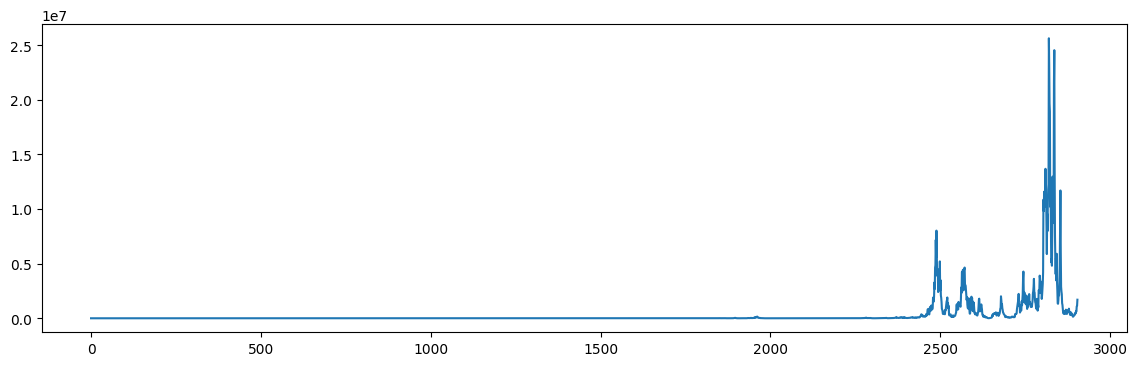

In [783]:
vol_rv = distributions.Normal(loc=torch.zeros(vol_locs.shape), 
                              scale=torch_model.sigma * torch.ones(vol_locs.shape))
vol_prior = vol_rv.log_prob(torch_model.vol)
_, vol_samples = torch_model()

display(vol_prior)
display(torch.exp(vol_samples))

fig, ax = plt.subplots(figsize=(14, 4))
y_vals = np.exp(vol_samples.cpu().detach().numpy())

s = pd.Series(y_vals)
s.plot()
#len(returns.index)
#len(y_vals)
#plt.plot(returns.index, y_vals, "k", alpha=0.002)
#ax.set_xlim(x_vals.min(), x_vals.max())
#ax.set_ylim(bottom=0)
#ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");
#display(sum(vol_prior))

In [666]:
torch_model.sigma.grad

tensor(0.0287, grad_fn=<SubBackward0>)

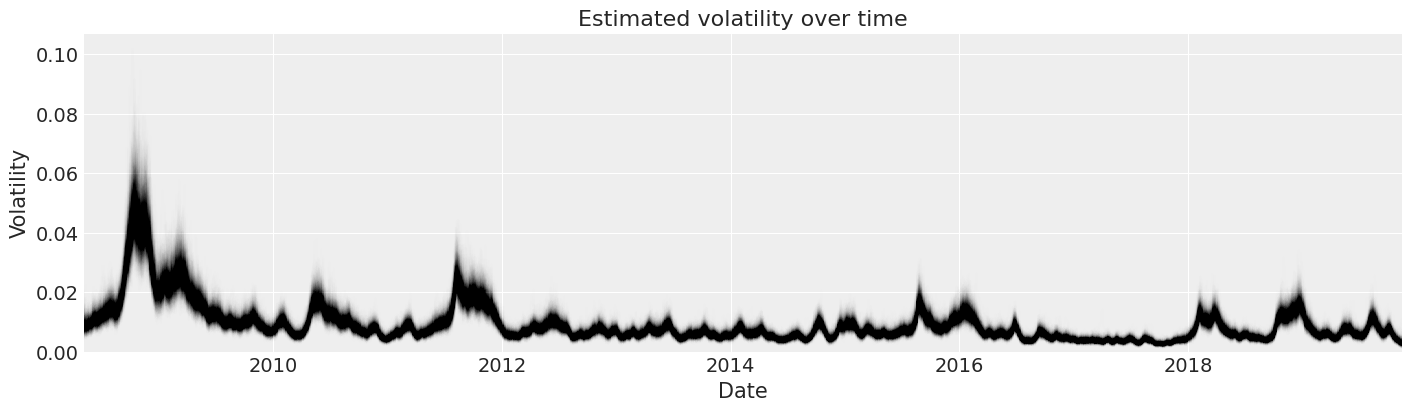

In [462]:
returns['change'].tail(100).describe()

count    100.000000
mean       0.000596
std        0.008548
min       -0.030230
25%       -0.003157
50%        0.000873
75%        0.005841
max        0.018588
Name: change, dtype: float64

# 2022-10-22

* Found another conceptual difference.  I need to sample from each random variable in my DAG using `::rsample()`.
  * So the actual parameters in my torch model are simply the parameters of the random variables (e.g. `sigma` is rate of my exponential step size dist, `self.vol` is mean for the random walk gaussians etc.)
  * So to do a forward pass, I sample from rate, then I sample from vol, then I sample from t-dist (and sample from degrees freedom somewhere)
  * This fixed a lot of issues:
       * We can now backprop all the way through to `self.sigma` instead of only through prior regularizer
       * Misintepreted sigma to be the sample, NOT the rate parameter

TODO:
* Take a look at results in more detail
* May have to do SGD batch-like behavior so that we can smooth the gradient updates (and to smooth the `rsamples`)

# 2022-10-20

* Realized `self.vol` was really just the differences between normal distributions, so the prior can just be evaluated using the $N(0, \sigma^2)$ distribution, simplifying the logic
* I realized the initial value of the Gaussian random walk matters a lot, otherwise there is a discontinuity in the first time step, which throws everything off.  I set it at roughly $log(0.01)$, which is close to the first value I see in the MCMC simulation. 
    * It roughly follows the shape of the posterior from MCMC
    * The scale is off though, most likely because $\sigma$ is very small -- still need to figure out what the deal with that is.
    
    
TODO:
* It also looks like the `vol_init` changes very slowly (along with DF).  Why is that?
    * Is this a case of vanishing gradient (it has to backprop through ~3000 timesteps)?
* Why does $\sigma$ always tend towards negative?  Still need to figure this out...


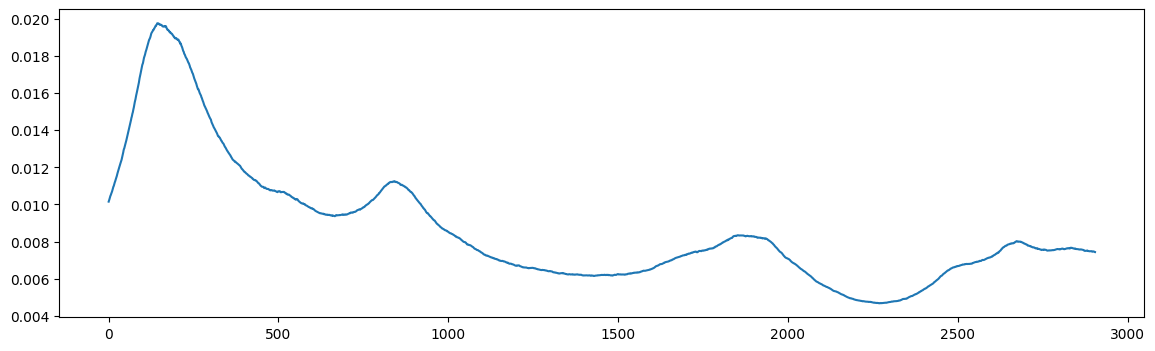

# 2022-10-15

* Fixed: Prior should not be multiplied by len(trace) because $P(X,Y|Z)P(Z) = P(X|Z) P(Y|Z)P(Z)$ where $X$ and $Y$ are conditionally independent given $Z$.  So we only need on prior ($Z$) not one for each of $X,Y$
* Did more debugging, seems like instability in gradient is causing some of my problems
    * See the gradient on sigma blows up for some reason.  Maybe this is like the RNN kind of problem with gradient instability and long traces (we do have a trace of ~3000)

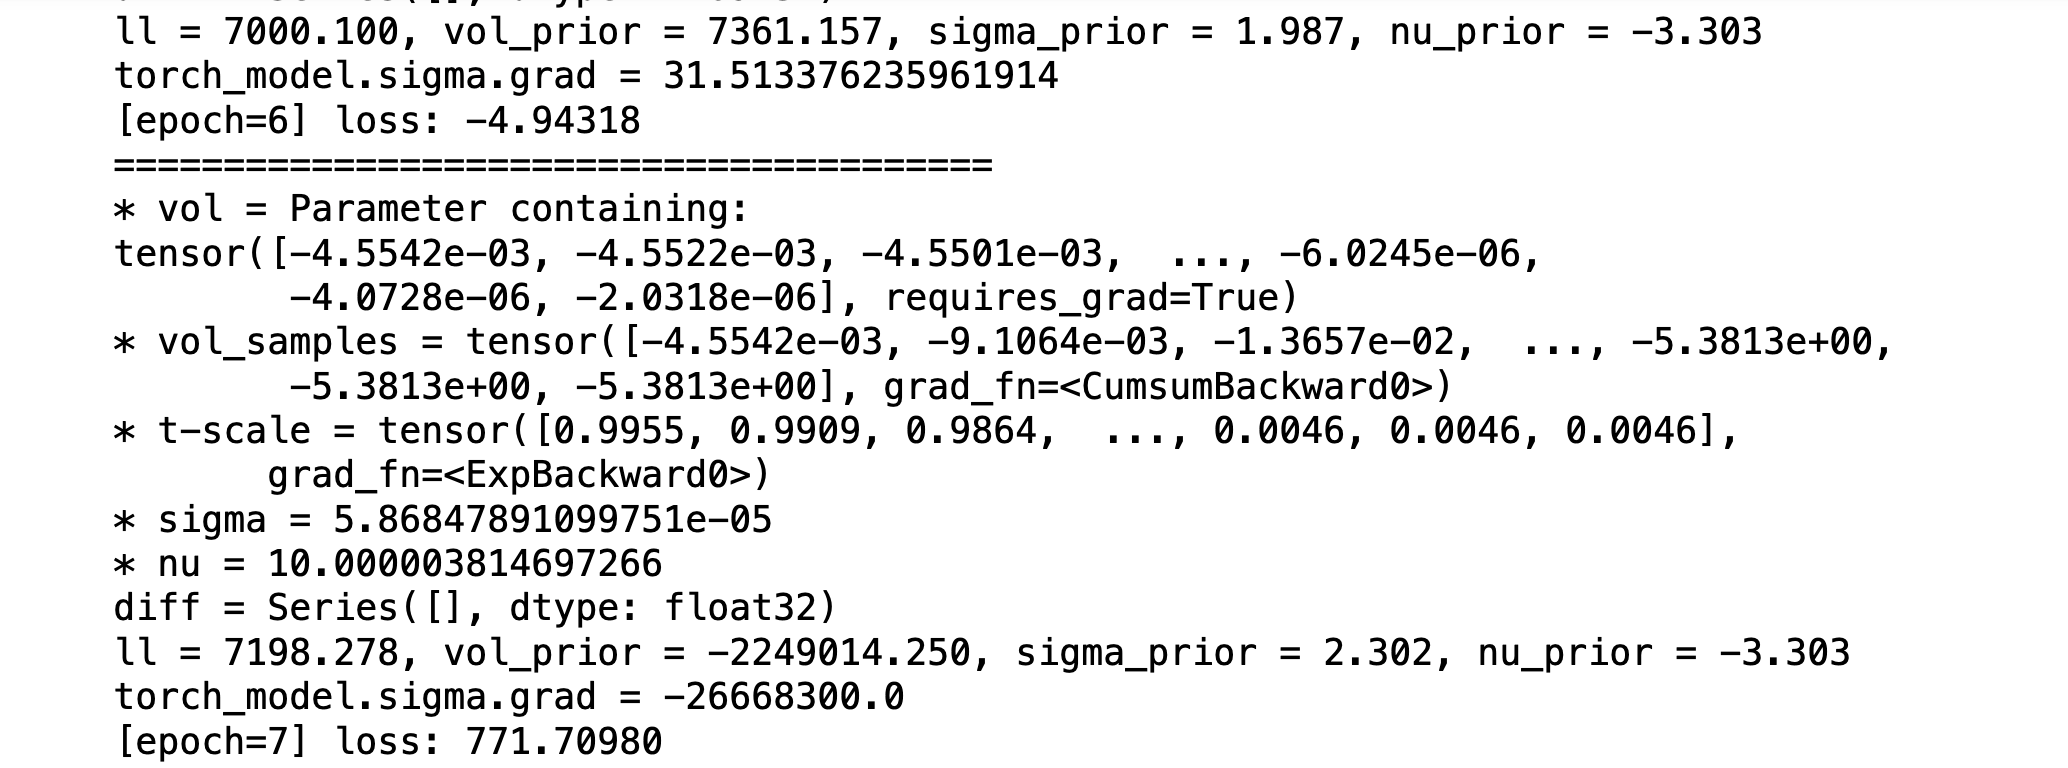

# 2022-10-10

* Had the modelling wrong, I need a Torch parameter for *each* latent variable in the model (not just the top level sigma/nu).  This means I need one for each step of the volatility random walk.
  * I also had a little bug with the reparameterization of t-dist from lambda to sigma (since they are inverse square of each other)
* Got it working, but... I still sometimes get negative values for \sigma since Torch doesn't care if it can eventually go negative.  I think the solution is to re-write it in terms of log(X) where X ~ exponentially distributed. See: https://math.stackexchange.com/questions/2244210/distribution-of-logx-for-exponentially-distributed-x
  * I did a hack by just taking ABS value of sigma, but that doesn't seem right.  Gradient seems off.
* Yeah the gradient of sigma gets huge after it gets close to 0, so I think I need the log parameterization or else the gradient is just going to be crazy.


TODO: 
* Use the log(X) trick to make sure \sigma doesn't go negative
* Double check logic again, sigma keeps going more negative, which is kind of odd why that would happen

# 2022-10-08

* Got the basic framework up for model in PyTorch
* Looks like $sigma$ is going negative though which causes error when used as scale for Gaussian

TODO:

* Double check the model specification, found errors in different parameterization of scales (in Normal and Gaussian)
* Also check loss function is doing what I think it should be...